In [99]:
from IPython.display import HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
!pip install git+https://github.com/renatopp/liac-arff@master
!pip install git+https://github.com/openml/openml-python.git@develop
!pip install mglearn
from IPython.display import set_matplotlib_formats, display, HTML
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml as oml
import mglearn
import os
from cycler import cycler
from pprint import pprint

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
#plt.rcParams['lines.linewidth'] = 1
plt.rcParams['legend.numpoints'] = 1
plt.rc('axes', prop_cycle=(cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
                           cycler('linestyle', ['-', '--', ':',
                                                '-.', '--'])
                           )
       )

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

np, mglearn

# Prints outputs in cells so that we don't have to write print() every time 
#InteractiveShell.ast_node_interactivity = "all"

# Matplotlib tweaks for presentations
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.max_open_warning"] = -1
plt.rcParams['font.size'] = 8; 
plt.rcParams['lines.linewidth'] = 0.5


# Presentations
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'width': '95%', 'height': 786, 'scroll': True, 'theme': 'solarized', 'transition': 'fade', 'overflow': 'visible', 'start_slideshow_at': 'selected'})

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import numpy as np

  Cloning https://github.com/renatopp/liac-arff (to master) to /tmp/pip-avauxvj_-build
  Cloning https://github.com/openml/openml-python.git (to develop) to /tmp/pip-brv7_mcj-build


# Foundations of Data Mining: Assignment 4

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

**Deadline:** Thursday, April 12, 2018

In [0]:
# Please fill in your names here
NAME_STUDENT_1 = "Jan-Niklas Schneider 1260421"
NAME_STUDENT_2 = "Georgiana Manolache 0876359"

In [0]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

###### Backpropagation (6 points)

Figure 1 illustrates a simple neural network model.

![Figure 1](images/a4_network.png)

It has single input $x$, and three layers with respectively one, two, and one neurons. The activation function of the neurons is ReLU. 

The parameters $w_1$, $w_2$, $w_3$, $w_4$, and $w_5$ (no biases) are initialized to the following values $w_1 = 2, w_2 = 1$, $w_3 = 2$, $w_4 = 4$, and $w_5 = 1$. Implement a single update step of the gradient descent algorithm by hand. Run the update state for the data point $(x=2, y=3)$:

The goal is to model the relationship between two continuous variables. The learning rate is set to $0.1$

Provide the solution in the following format:

- A choice for a loss function 
- Compute graph for training the neural network
- Partial derivative expression for each of the parameters in the model
- The update expression for each of the parameters for each of the data-points
- The final value of all five parameters after the single step in the gradient descent algorithm

The Python code for simple computational graph nodes, as seen in the tutorial session, is provided in the cell below (run the cell to load the code, and again to run the code). Extend the nodes so they can be used to implement the network described above. Implement the network with the same initial weights and the correct learning rate, and verify your hand-made calculations. Add comments to your code or provide a separate description to explain the changes you have made.

In [78]:
# %load basic_graph.py
'''
Implementations of nodes for a computation graph. Each node
has a forward pass and a backward pass function, allowing
for the evaluation and backpropagation of data.
'''

from abc import ABC, abstractmethod
import math
import time


class Node(object):

    def __init__(self, inputs):
        self.inputs = inputs

    @abstractmethod
    def forward(self):
       ''' Feed-forward the result '''
       return inputs[0]
       

    @abstractmethod
    def backward(self, d):
        ''' Back-propagate the error
            d is the delta of the subsequent node in the network '''
        pass


class ConstantNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        pass


class VariableNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        self.output -= 0.1 * d # Gradient Descent


class AdditionNode(Node):

    def forward(self):
        self.output = sum([i.forward() for i in self.inputs])
        return self.output

    def backward(self, d):
        for i in self.inputs:
            i.backward(d)


class MultiplicationNode(Node):

    def forward(self):
        self.output = self.inputs[0].forward() * self.inputs[1].forward()
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.inputs[1].output)
        self.inputs[1].backward(d * self.inputs[0].output)


class MSENode(Node):

    def forward(self):
        self.output = 0.5 * (
            self.inputs[0].forward() - self.inputs[1].forward())**2
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * (self.inputs[0].output - self.inputs[1].output))
        self.inputs[1].backward(d * (self.inputs[1].output - self.inputs[0].output))


class SigmoidNode(Node):

    def forward(self):
        self.output = 1.0 / (1.0 + math.exp(-self.inputs[0].forward()))
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.output * (1.0 - self.output))

# forward: This method is very well presented by np.max function
# such that we can express ReLU
# backward: ReLU does not have a derivate such that d is multiplied by 1
# below 0 we multiply 0 so we receive 0
class ReLUNode(Node):
    
    def forward(self):
        self.output = np.maximum(self.inputs[0].forward(), 0)
        return self.output

    def backward(self, d):
        if self.output > 0:
            self.inputs[0].backward(d*1)
        else:
            self.inputs[0].backward(d*0)

# forward: an implementation is present in numpy
# backward: the derivative of the function used in backprop.
class TanhNode(Node):

    def forward(self):
        self.output = np.tanh(self.inputs[0])
        return self.output

    def backward(self, d):
        self.inputs[0].backward(1 - ((np.tanh(self.inputs[0].forward())) ** 2)) 

      
# Example graph as shown in MLP lecture slides
class SampleGraph(object):

    def __init__(self, x, y, w, b):
        ''' x: input
            y: expected output
            w: initial weight
            b: initial bias '''
        self.w = VariableNode(w)
        self.b = VariableNode(b)
        self.graph = MSENode([
            AdditionNode([
                MultiplicationNode([
                    ConstantNode(x),
                    self.w
                ]),
                MultiplicationNode([
                    self.b,
                    ConstantNode(1)
                ])
            ]),
            ConstantNode(y)
        ])

    def forward(self):
        return self.graph.forward()

    def backward(self, d):
        self.graph.backward(d)


class Neuron(Node):

    def __init__(self, inputs, weights, activation):
        ''' weights: list of initial weights, same length as inputs '''
        self.inputs = inputs
        # Initialize a weight for each input
        self.weights = [VariableNode(weight) for weight in weights]
        # Neurons normally have a bias, ignore for this assignment
        #self.bias = VariableNode(bias, "b")

        # Multiplication node for each pair of inputs and weights
        mults = [MultiplicationNode([i, w]) for i, w, in zip(self.inputs, self.weights)]
        # Neurons normally have a bias, ignore for this assignment
        #mults.append(MultiplicationNode([self.bias, ConstantNode(1)]))

        # Sum all multiplication results
        added = AdditionNode(mults)

        # Apply activation function
        if activation == 'sigmoid':
            self.graph = SigmoidNode([added])
        elif activation == 'relu':
            self.graph = ReLUNode([added])
        elif activation == 'tanh':
            self.graph = TanhNode([added])
        else:
            raise ValueError("Unknown activation function.")

    def forward(self):
      #       added this to use the output in backprop.
      self.output = self.graph.forward()
      return self.graph.forward()


    def backward(self, d):
        self.graph.backward(d)

    def set_weights(self, new_weights):
        for i in len(new_weights):
            self.weights[i].output = new_weights[i]

    def get_weights(self):
        return [weight.output for weight in self.weights]

if __name__ == '__main__':
    print("Loaded simple graph nodes")
   
    # Example network
    #sg = SampleGraph(2, 2, 2, 1)
    #prediction = sg.forward()
    #print("Initial prediction is", prediction)
    #sg.backward(1)
    #print("w has new value", sg.w.output)
    #print("b has new value", sg.b.output)
    
    
    # Run your network here
    w1 = 2
    w2 = 1
    w3 = 2
    w4 = 4
    w5 = 1
    x = 2
    y = 3
    
    inputs = [ConstantNode(x)] 
              
    n1 = Neuron(inputs, [w1], 'relu')
    n1.forward()
    
    n2 = Neuron([n1], [w2], 'relu')
    n2.forward()

    n3 = Neuron([n1], [w3], 'relu')
    n3.forward()
    
    n4 = Neuron([n2,n3], [w4,w5], 'relu')
    n4.forward()
    
    mse = MSENode([n4, ConstantNode(y)])
    print("mse forward: {}".format(mse.forward()))
    
    mse_b_prop = mse.backward(1)
    print("w1 after backpropagation: {}".format(n1.get_weights()[0]))
    print("w2 after backpropagation: {}".format(n2.get_weights()[0]))
    print("w3 after backpropagation: {}".format(n3.get_weights()[0]))
    print("w4 after backpropagation: {}".format(n4.get_weights()[0]))
    print("w5 after backpropagation: {}".format(n4.get_weights()[1]))
    

Loaded simple graph nodes
mse forward: 220.5
w1 after backpropagation: -23.200000000000003
w2 after backpropagation: -32.6
w3 after backpropagation: -6.4
w4 after backpropagation: -4.4
w5 after backpropagation: -15.8


Given information: $x = 2, y = 3, w_1 = 2, w_2 = 1, w_3 = 2, w_4 = 4, w_5 = 1$. Further we have nodes $n_{1\dots4}$ and the $mse$ node. Nodes $n_{1\dots4}$ utilize ReLU as their activation function thus we calculate the forward propragtion as follows:

$n_1 = max\{x*w_1, 0\} = max\{2*2, 0\} = 4$

$n_2 = max\{n_1*w_2, 0\} = max\{1*4, 0\} = 4$

$n_3 = max\{n_1*w_3, 0\} = max\{2*4, 0\} = 8$

$n_4 = max\{n_2*w_4 + n_3*w_5, 0\} = max\{4*4 + 1*8, 0\} = 24$

$mse = \frac{1}{2}(n_4 - y)^2 = \frac{1}{2}(24 - 3)^2 = 220\frac{1}{2}$

Backpropagation:

$\frac{\delta L}{\delta L} = 1$

$\frac{\delta L}{\delta n_4} = \frac{\delta}{\delta n_4}\frac{1}{2}(n_4 - y)^2 = n_4 - y$

$\frac{\delta L}{\delta w_5} = \frac{\delta L}{\delta n_4} \frac{\delta n_4}{\delta w_5} = n_3(n_4 - y) = 168$

$\frac{\delta L}{\delta w_4} =  \frac{\delta n_4}{\delta w_4}\frac{\delta n_4}{\delta w_4} = n_2(n_4 - y) = 84$

$\frac{\delta L}{\delta w_3} = \frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta n_3}\frac{\delta n_3}{\delta w_3} = w_5n_1(n_4 - y) = 84$

$\frac{\delta L}{\delta w_1} = \frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta n_2}\frac{\delta n_2}{\delta n_1}\frac{\delta n_1}{\delta w_1} + \frac{\delta L}{\delta n_4}\frac{\delta n_4}{\delta n_3}\frac{\delta n_2}{\delta n_1}\frac{\delta n_1}{\delta w_1} = (w_5w_3+w_4w_2)(n_4 -y) = 252$

Adjust weights by $w_i - \alpha\frac{\delta L}{\delta w_i}$

$w_1 = 2-(\frac{1}{10}*252) = -23\frac{1}{5}$

$w_2 = 1-(\frac{1}{10}*336) = -32\frac{3}{5}$

$w_3 = 2-(\frac{1}{10}*84) = -6\frac{2}{5}$

$w_4 = 4-(\frac{1}{10}*84) = -4\frac{2}{5}$

$w_5 = 1-(\frac{1}{10}*168) = -15\frac{4}{5}$

## Training Deep Models (3 points)

The model in the example code below performs poorly as its depth increases. Train this model on the MNIST digit detection task. 

Examine its training performance by gradually increasing its depth:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Modify the model such that you improve its performance when its depth increases. Train the new model again for the different depths:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Submit an explanation for the limitation of the original model. Explain your modification. 
Submit your code and 6 plots (can be overlaid) for the training performance of both models with different depths. 



In [0]:
# (You don't need to change this part of the code)
from __future__ import print_function
import numpy as np
np.random.seed(1234)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils


import matplotlib.pyplot as plt

batch_size = 128
nb_classes = 10
nb_epoch = 10

In [28]:
# (You don't need to change this part of the code)
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

60000 train samples
10000 test samples


First we build the models. We increase depth gradually by modifing the number of hidden layers (1,2,3).

In [42]:
models=[]
#loop through each hidden layer
for hidlayer in [1,2,3]:  
    print("# hidden layers {}".format(hidlayer))
    
    model = Sequential()
    model.add(Dense(512, input_shape=(784,), activation='sigmoid'))
    model.add(Dropout(0.2))
 
    while hidlayer > 1:
        model.add(Dense(512))
        model.add(Activation('sigmoid'))#signmoid
        model.add(Dropout(0.2))
        hidlayer -= 1
      
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])
   
    #save model
    models.append(model)  

# hidden layers 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
# hidden layers 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
__________________________________

Than we train the models gradually.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 62us/step - loss: 1.9751 - acc: 0.3694 - val_loss: 1.5840 - val_acc: 0.7205
Epoch 2/10
60000/60000 [==============================] - 3s 48us/step - loss: 1.4258 - acc: 0.6418 - val_loss: 1.1469 - val_acc: 0.8018
Epoch 3/10
60000/60000 [==============================] - 3s 49us/step - loss: 1.0980 - acc: 0.7308 - val_loss: 0.8980 - val_acc: 0.8318
Epoch 4/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.9050 - acc: 0.7711 - val_loss: 0.7538 - val_acc: 0.8408
Epoch 5/10
39680/60000 [==================>...........] - ETA: 0s - loss: 0.8033 - acc: 0.7888

60000/60000 [==============================] - 3s 49us/step - loss: 0.7891 - acc: 0.7922 - val_loss: 0.6592 - val_acc: 0.8561
Epoch 6/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.7096 - acc: 0.8099 - val_loss: 0.5966 - val_acc: 0.8645
Epoch 7/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.6544 - acc: 0.8201 - val_loss: 0.5501 - val_acc: 0.8689
Epoch 8/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.6117 - acc: 0.8314 - val_loss: 0.5154 - val_acc: 0.8757
Epoch 9/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.5801 - acc: 0.8376 - val_loss: 0.4878 - val_acc: 0.8794
Epoch 10/10
 5760/60000 [=>............................] - ETA: 2s - loss: 0.5672 - acc: 0.8408

60000/60000 [==============================] - 3s 48us/step - loss: 0.5525 - acc: 0.8441 - val_loss: 0.4659 - val_acc: 0.8828

# hidden layers 1
test score 0.46587126257419587
test accuracy 0.8828
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


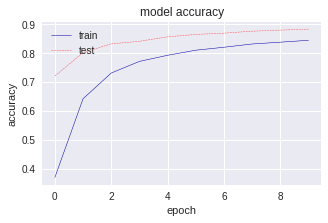

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 58us/step - loss: 2.3309 - acc: 0.1181 - val_loss: 2.2311 - val_acc: 0.2600
Epoch 2/10
60000/60000 [==============================] - 3s 56us/step - loss: 2.2461 - acc: 0.1733 - val_loss: 2.1475 - val_acc: 0.3765
Epoch 3/10
60000/60000 [==============================] - 3s 55us/step - loss: 2.1563 - acc: 0.2437 - val_loss: 2.0365 - val_acc: 0.5464
Epoch 4/10
60000/60000 [==============================] - 3s 56us/step - loss: 2.0270 - acc: 0.3341 - val_loss: 1.8793 - val_acc: 0.6458
Epoch 5/10
18944/60000 [========>.....................] - ETA: 2s - loss: 1.9252 - acc: 0.3969

60000/60000 [==============================] - 3s 57us/step - loss: 1.8601 - acc: 0.4263 - val_loss: 1.6775 - val_acc: 0.6945
Epoch 6/10
60000/60000 [==============================] - 3s 56us/step - loss: 1.6593 - acc: 0.5049 - val_loss: 1.4548 - val_acc: 0.6962
Epoch 7/10
60000/60000 [==============================] - 3s 55us/step - loss: 1.4552 - acc: 0.5693 - val_loss: 1.2508 - val_acc: 0.7269
Epoch 8/10
60000/60000 [==============================] - 3s 56us/step - loss: 1.2743 - acc: 0.6195 - val_loss: 1.0842 - val_acc: 0.7548
Epoch 9/10
47744/60000 [======================>.......] - ETA: 0s - loss: 1.1452 - acc: 0.6557

60000/60000 [==============================] - 3s 56us/step - loss: 1.1331 - acc: 0.6587 - val_loss: 0.9561 - val_acc: 0.7888
Epoch 10/10
60000/60000 [==============================] - 3s 55us/step - loss: 1.0213 - acc: 0.6907 - val_loss: 0.8592 - val_acc: 0.7942

# hidden layers 2
test score 0.8591637758255005
test accuracy 0.7942
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


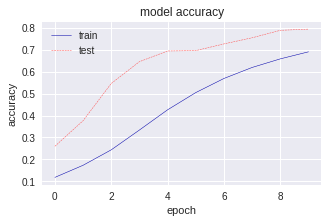

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 65us/step - loss: 2.3612 - acc: 0.1022 - val_loss: 2.3004 - val_acc: 0.1135
Epoch 2/10
60000/60000 [==============================] - 4s 63us/step - loss: 2.3467 - acc: 0.1037 - val_loss: 2.2929 - val_acc: 0.1833
Epoch 3/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.3396 - acc: 0.1073 - val_loss: 2.2902 - val_acc: 0.1036
Epoch 4/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.3271 - acc: 0.1129 - val_loss: 2.2820 - val_acc: 0.1926
Epoch 5/10
 2048/60000 [>.............................] - ETA: 3s - loss: 2.3283 - acc: 0.1104

60000/60000 [==============================] - 4s 63us/step - loss: 2.3196 - acc: 0.1132 - val_loss: 2.2771 - val_acc: 0.1028
Epoch 6/10
60000/60000 [==============================] - 4s 62us/step - loss: 2.3114 - acc: 0.1203 - val_loss: 2.2720 - val_acc: 0.1135
Epoch 7/10
60000/60000 [==============================] - 4s 63us/step - loss: 2.3027 - acc: 0.1273 - val_loss: 2.2628 - val_acc: 0.1758
Epoch 8/10
60000/60000 [==============================] - 4s 64us/step - loss: 2.2924 - acc: 0.1354 - val_loss: 2.2574 - val_acc: 0.2730
Epoch 9/10
26496/60000 [============>.................] - ETA: 2s - loss: 2.2858 - acc: 0.1390

60000/60000 [==============================] - 4s 64us/step - loss: 2.2836 - acc: 0.1411 - val_loss: 2.2465 - val_acc: 0.2664
Epoch 10/10
60000/60000 [==============================] - 4s 65us/step - loss: 2.2709 - acc: 0.1551 - val_loss: 2.2346 - val_acc: 0.3436

# hidden layers 3
test score 2.234564525604248
test accuracy 0.3436
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


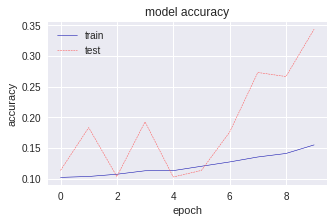

In [43]:
histories = []
for model,hidlayer in zip(models,[1,2,3]):
    
    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=1, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    
    print("\n# hidden layers {}".format(hidlayer))
    print("test score {}".format(score[0]))
    print("test accuracy {}".format(score[1]))
    
    histories.append(history)
    
    print(history.history.keys())
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

New version

In [44]:
models_2=[]

#loop through each hidden layer
for hidlayer in [1,2,3]:
  
    print("# hidden layers {}".format(hidlayer))

    model = Sequential()
    model.add(Dense(512, input_shape=(784,), activation='sigmoid'))
    model.add(Dropout(0.2))

    while hidlayer > 1:
        model.add(Dense(512))
        model.add(Activation('relu'))#changed to relu
        model.add(Dropout(0.2))
        hidlayer -= 1

    #append each model
    models_2.append(model)
        
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

# hidden layers 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_7 (Activation)    (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
# hidden layers 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
__________________________________

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 53us/step - loss: 2.0260 - acc: 0.3422 - val_loss: 1.6438 - val_acc: 0.7391
Epoch 2/10
60000/60000 [==============================] - 3s 49us/step - loss: 1.4794 - acc: 0.6303 - val_loss: 1.1929 - val_acc: 0.8007
Epoch 3/10
60000/60000 [==============================] - 3s 49us/step - loss: 1.1332 - acc: 0.7262 - val_loss: 0.9248 - val_acc: 0.8348
Epoch 4/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.9263 - acc: 0.7693 - val_loss: 0.7658 - val_acc: 0.8433
Epoch 5/10
40192/60000 [===================>..........] - ETA: 0s - loss: 0.8145 - acc: 0.7886

60000/60000 [==============================] - 3s 48us/step - loss: 0.8001 - acc: 0.7915 - val_loss: 0.6663 - val_acc: 0.8546
Epoch 6/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.7173 - acc: 0.8086 - val_loss: 0.6009 - val_acc: 0.8655
Epoch 7/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.6568 - acc: 0.8209 - val_loss: 0.5517 - val_acc: 0.8703
Epoch 8/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.6157 - acc: 0.8293 - val_loss: 0.5163 - val_acc: 0.8741
Epoch 9/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.5814 - acc: 0.8363 - val_loss: 0.4877 - val_acc: 0.8812
Epoch 10/10
 8448/60000 [===>..........................] - ETA: 2s - loss: 0.5624 - acc: 0.8413

60000/60000 [==============================] - 3s 48us/step - loss: 0.5550 - acc: 0.8434 - val_loss: 0.4660 - val_acc: 0.8818

# hidden layers 1
test score 0.46602701029777527
test accuracy 0.8818
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


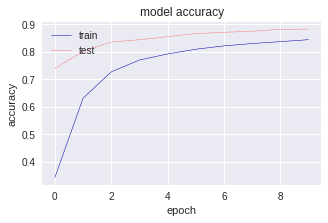

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 60us/step - loss: 2.0872 - acc: 0.2903 - val_loss: 1.6484 - val_acc: 0.6574
Epoch 2/10
60000/60000 [==============================] - 3s 56us/step - loss: 1.4462 - acc: 0.5750 - val_loss: 1.0081 - val_acc: 0.7809
Epoch 3/10
60000/60000 [==============================] - 3s 56us/step - loss: 1.0106 - acc: 0.6942 - val_loss: 0.7070 - val_acc: 0.8410
Epoch 4/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.8047 - acc: 0.7512 - val_loss: 0.5778 - val_acc: 0.8561
Epoch 5/10
19072/60000 [========>.....................] - ETA: 2s - loss: 0.7358 - acc: 0.7725

60000/60000 [==============================] - 3s 56us/step - loss: 0.6999 - acc: 0.7827 - val_loss: 0.5005 - val_acc: 0.8681
Epoch 6/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.6352 - acc: 0.8022 - val_loss: 0.4584 - val_acc: 0.8764
Epoch 7/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.5890 - acc: 0.8162 - val_loss: 0.4264 - val_acc: 0.8811
Epoch 8/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.5563 - acc: 0.8267 - val_loss: 0.4041 - val_acc: 0.8864
Epoch 9/10
47744/60000 [======================>.......] - ETA: 0s - loss: 0.5313 - acc: 0.8360

60000/60000 [==============================] - 3s 57us/step - loss: 0.5294 - acc: 0.8368 - val_loss: 0.3872 - val_acc: 0.8898
Epoch 10/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.5096 - acc: 0.8430 - val_loss: 0.3733 - val_acc: 0.8933

# hidden layers 1
test score 0.373338038790226
test accuracy 0.8933
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


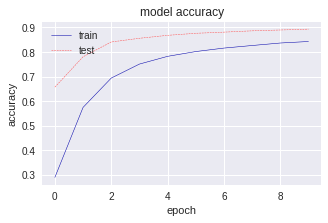

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 68us/step - loss: 2.1703 - acc: 0.2292 - val_loss: 1.7619 - val_acc: 0.6856
Epoch 2/10
60000/60000 [==============================] - 4s 64us/step - loss: 1.5400 - acc: 0.5008 - val_loss: 0.9328 - val_acc: 0.7649
Epoch 3/10
60000/60000 [==============================] - 4s 65us/step - loss: 1.0257 - acc: 0.6590 - val_loss: 0.6279 - val_acc: 0.8310
Epoch 4/10
60000/60000 [==============================] - 4s 63us/step - loss: 0.8112 - acc: 0.7287 - val_loss: 0.5177 - val_acc: 0.8493
Epoch 5/10
 1920/60000 [..............................] - ETA: 3s - loss: 0.7418 - acc: 0.7536

60000/60000 [==============================] - 4s 64us/step - loss: 0.7012 - acc: 0.7697 - val_loss: 0.4607 - val_acc: 0.8639
Epoch 6/10
60000/60000 [==============================] - 4s 63us/step - loss: 0.6378 - acc: 0.7926 - val_loss: 0.4293 - val_acc: 0.8725
Epoch 7/10
60000/60000 [==============================] - 4s 64us/step - loss: 0.5915 - acc: 0.8107 - val_loss: 0.4028 - val_acc: 0.8807
Epoch 8/10
60000/60000 [==============================] - 4s 64us/step - loss: 0.5610 - acc: 0.8211 - val_loss: 0.3808 - val_acc: 0.8874
Epoch 9/10
26368/60000 [============>.................] - ETA: 2s - loss: 0.5421 - acc: 0.8282

60000/60000 [==============================] - 4s 64us/step - loss: 0.5347 - acc: 0.8309 - val_loss: 0.3637 - val_acc: 0.8927
Epoch 10/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.5087 - acc: 0.8390 - val_loss: 0.3503 - val_acc: 0.8958

# hidden layers 1
test score 0.350299120926857
test accuracy 0.8958
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


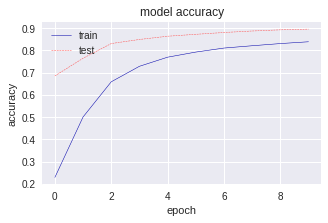

In [45]:
histories_2 = []

for model,hidlayers in zip(models_2,[1,2,3]):
    
    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=1, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    
    print("\n# hidden layers {}".format(hidlayer))
    print("test score {}".format(score[0]))
    print("test accuracy {}".format(score[1]))
    
    histories_2.append(history)
    
    print(history.history.keys())
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
# format the input sets, add the digits and their sums
def plot_models(histories, pos, model):  
  count = 1
  for history,hidlayers in zip(histories,[1,2,3]):
    fig.add_subplot(2,3,count+pos)
    count += 1
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('{1} model with # hidden layers {2}'.format(model, hidlayers))
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
   

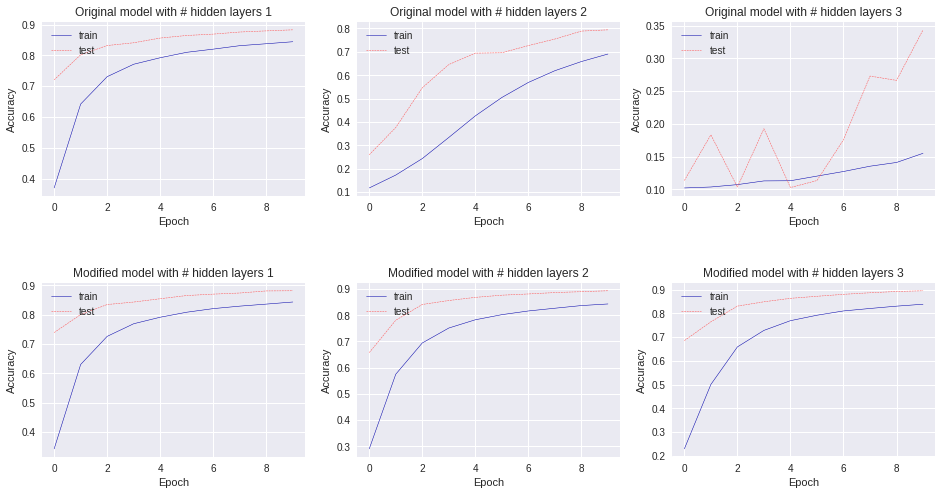

In [46]:
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(hspace=.5)

plot_models(histories, 0, 'Original')
plot_models(histories, 3, 'Modified')
plt.show()

To improve models performance when depth increases activation, function of the hidden layers was changed to ReLU. In the original model, the accuracy decreases when increasing the number of hidden layers (first row). While test data accuracy resulted better than the one on training data, it is still low. In the modified models, reasonable accuracy score is obtain in ten epochs. Furthermore, with the increase of number of hidden layers, the accuracy score also get better.


## MNIST Calculator (6 points)

During the lectures you have seen a CNN model that can be successfully trained to classify the MNIST images. You have also seen how a RNN model that can be trained to implement addition of two numbers. You now need to build a model that is a combination of convolutional layers and recurrent cells. 

Using the KERAS library, design and train a model that produces a sum of a sequence of MNIST images. More specifically, the model should input a sequence of 10 images and compute the cumulative sum of the digits represented by the images.

For example:

Input 1: ![294](images/a3ex1.png)

Output 1: 46

Input 2: ![61](images/a3ex2.png)

Output 2: 43

Your solutions should include:
- Python code that formats the MNIST dataset such that it can be used for traning and testing your model
- Implementation in keras of your model (for training and testing)
- Performance on the model on test data
- Justification (in text) of your decisions for the model architecture (type of layers, activation functions, loss function, regularization and training hyperparameters)

Note: Use the 60000/10000 train/test split of the MNIST dataset


In [101]:
# Provide your solution here
import keras
from keras.datasets import mnist

classes = 10

# (You don't need to change this part of the code)
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

60000 train samples
10000 test samples


In [0]:
# format the input sets, add the digits and their sum
def format_data(X, y):
  X_new = []
  y_new = []
  for i in range(len(X)):
      digits = []
      sum_digits = 0
      for k in range(i, i+10):
          if k >= len(X):
            k=k%len(X)
          digits.append(X[k])
          sum_digits += np.argmax(Y[k])
      X_new.append(digits)
      y_new.append(sum_digits)
      
  return X_new, y_new

In [0]:
X_train, y_train = format_data(X_train, y_train)
X_test, y_test = format_data(X_test, y_test)

In [104]:
X_train = [np.array(item).reshape(10, 28, 28, 1) for item in X_train]
X_test = [np.array(item).reshape(10, 28, 28, 1) for item in X_test]
X_train = np.reshape(np.array(X_train), (60000, 10, 28, 28, 1))
X_test = np.reshape(np.array(X_test), (10000, 10, 28, 28, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (60000, 10, 28, 28, 1)
y_train:  (60000,)
X_test:  (10000, 10, 28, 28, 1)
y_test:  (10000,)


In [87]:
from keras.layers import Activation, Dense, Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, GRU
from keras.models import Model

# Get a tensor with the output of our vision model:
inputs = Input(shape=(10, 28, 28, 1))

# First, define the vision modules
# 3x3 conv with 32 and 63 output channels (same as input channels)
x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(inputs)
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Flatten())(x)
x = GRU(100, return_sequences=True)(x)
x = GRU(50, return_sequences=False)(x)
x = Dropout(.2)(x)
# Train a logistic regression
output = Dense(1)(x)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=RMSprop(lr=0.00005),metrics=['accuracy'], loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 10, 28, 28, 1)     0         
_________________________________________________________________
time_distributed_219 (TimeDi (None, 10, 28, 28, 32)    320       
_________________________________________________________________
time_distributed_220 (TimeDi (None, 10, 26, 26, 32)    9248      
_________________________________________________________________
time_distributed_221 (TimeDi (None, 10, 13, 13, 32)    0         
_________________________________________________________________
time_distributed_222 (TimeDi (None, 10, 13, 13, 32)    0         
_________________________________________________________________
time_distributed_223 (TimeDi (None, 10, 13, 13, 64)    18496     
_________________________________________________________________
time_distributed_224 (TimeDi (None, 10, 11, 11, 64)    36928     
__________

In [88]:
batch_size = 128
epochs = 30

for count in range(0, epochs):
    print()
    print('-' * 50)
    print('epoch ', count+1)
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=1,
              validation_data=(X_test, y_test))
    
    for i in range(10):
        index = np.random.randint(0, 10000)
        pred = np.round(model.predict(np.reshape(X_test[index], (1, 10, 28, 28, 1)), verbose=0)[0][0]).astype(int)
        correct =  y_test[index]
        if pred == correct:
          print("pred: {0}, answer: {1},  {2}".format(pred, correct, "pass"))
        else:
          print("pred: {0}, answer: {1},  {2}".format(pred, correct, "fail"))
        
score = model.evaluate(X_test, y_test, verbose=0)
print('\ntest loss:', score[0])
print('test accuracy:', score[1])


--------------------------------------------------
epoch  1
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
58624/60000 [============================>.] - ETA: 2s - loss: 1006.2716 - acc: 5.2879e-04

60000/60000 [==============================] - 97s 2ms/step - loss: 998.5403 - acc: 6.0000e-04 - val_loss: 646.8718 - val_acc: 0.0012
pred: 21, answer: 46,  fail
pred: 21, answer: 43,  fail
pred: 21, answer: 50,  fail
pred: 21, answer: 54,  fail
pred: 21, answer: 35,  fail
pred: 21, answer: 70,  fail
pred: 21, answer: 40,  fail
pred: 21, answer: 37,  fail
pred: 21, answer: 34,  fail
pred: 21, answer: 52,  fail

--------------------------------------------------
epoch  2
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
19968/60000 [========>.....................] - ETA: 59s - loss: 575.4106 - acc: 0.0031

60000/60000 [==============================] - 94s 2ms/step - loss: 429.0069 - acc: 0.0080 - val_loss: 225.6357 - val_acc: 0.0181
pred: 32, answer: 40,  fail
pred: 32, answer: 42,  fail
pred: 32, answer: 38,  fail
pred: 32, answer: 40,  fail
pred: 32, answer: 42,  fail
pred: 32, answer: 24,  fail
pred: 32, answer: 48,  fail
pred: 32, answer: 50,  fail
pred: 32, answer: 51,  fail
pred: 32, answer: 34,  fail

--------------------------------------------------
epoch  3
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14848/60000 [======>.......................] - ETA: 1:07 - loss: 211.0914 - acc: 0.0225

60000/60000 [==============================] - 94s 2ms/step - loss: 148.0146 - acc: 0.0316 - val_loss: 82.4594 - val_acc: 0.0412
pred: 43, answer: 47,  fail
pred: 43, answer: 56,  fail
pred: 43, answer: 47,  fail
pred: 43, answer: 61,  fail
pred: 43, answer: 40,  fail
pred: 43, answer: 45,  fail
pred: 43, answer: 36,  fail
pred: 43, answer: 45,  fail
pred: 43, answer: 56,  fail
pred: 43, answer: 59,  fail

--------------------------------------------------
epoch  4
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 100.3027 - acc: 0.0395

60000/60000 [==============================] - 94s 2ms/step - loss: 99.5136 - acc: 0.0388 - val_loss: 81.5676 - val_acc: 0.0365
pred: 44, answer: 39,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 53,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 76,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 61,  fail
pred: 44, answer: 50,  fail
pred: 44, answer: 48,  fail

--------------------------------------------------
epoch  5
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 99.0797 - acc: 0.0373

60000/60000 [==============================] - 94s 2ms/step - loss: 99.6822 - acc: 0.0379 - val_loss: 81.6155 - val_acc: 0.0365
pred: 44, answer: 44,  pass
pred: 44, answer: 28,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 54,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 40,  fail
pred: 44, answer: 51,  fail
pred: 44, answer: 49,  fail

--------------------------------------------------
epoch  6
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 98.4369 - acc: 0.0376

60000/60000 [==============================] - 94s 2ms/step - loss: 99.5230 - acc: 0.0398 - val_loss: 81.5948 - val_acc: 0.0365
pred: 44, answer: 38,  fail
pred: 44, answer: 39,  fail
pred: 44, answer: 43,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 55,  fail
pred: 44, answer: 54,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 31,  fail
pred: 44, answer: 29,  fail

--------------------------------------------------
epoch  7
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 99.3388 - acc: 0.0386

60000/60000 [==============================] - 94s 2ms/step - loss: 99.6048 - acc: 0.0396 - val_loss: 81.5684 - val_acc: 0.0365
pred: 44, answer: 45,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 46,  fail
pred: 44, answer: 28,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 51,  fail
pred: 44, answer: 53,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 44,  pass

--------------------------------------------------
epoch  8
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 100.6305 - acc: 0.0398

60000/60000 [==============================] - 94s 2ms/step - loss: 99.5579 - acc: 0.0388 - val_loss: 81.5839 - val_acc: 0.0365
pred: 44, answer: 46,  fail
pred: 44, answer: 39,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 39,  fail
pred: 44, answer: 56,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 62,  fail
pred: 44, answer: 59,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 38,  fail

--------------------------------------------------
epoch  9
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 98.6295 - acc: 0.0409

60000/60000 [==============================] - 94s 2ms/step - loss: 99.1930 - acc: 0.0393 - val_loss: 81.5926 - val_acc: 0.0365
pred: 44, answer: 50,  fail
pred: 44, answer: 30,  fail
pred: 44, answer: 34,  fail
pred: 44, answer: 59,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 53,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 53,  fail

--------------------------------------------------
epoch  10
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14080/60000 [======>.......................] - ETA: 1:08 - loss: 99.7464 - acc: 0.0383

60000/60000 [==============================] - 94s 2ms/step - loss: 99.1078 - acc: 0.0384 - val_loss: 81.5813 - val_acc: 0.0365
pred: 44, answer: 27,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 32,  fail
pred: 44, answer: 34,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 54,  fail
pred: 44, answer: 45,  fail

--------------------------------------------------
epoch  11
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 99.8074 - acc: 0.0396

60000/60000 [==============================] - 94s 2ms/step - loss: 99.6026 - acc: 0.0393 - val_loss: 81.5748 - val_acc: 0.0365
pred: 44, answer: 43,  fail
pred: 44, answer: 34,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 33,  fail
pred: 44, answer: 54,  fail
pred: 44, answer: 32,  fail
pred: 44, answer: 37,  fail
pred: 44, answer: 34,  fail
pred: 44, answer: 55,  fail
pred: 44, answer: 64,  fail

--------------------------------------------------
epoch  12
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14080/60000 [======>.......................] - ETA: 1:08 - loss: 98.5335 - acc: 0.0400

60000/60000 [==============================] - 94s 2ms/step - loss: 98.7865 - acc: 0.0390 - val_loss: 81.5737 - val_acc: 0.0365
pred: 44, answer: 54,  fail
pred: 44, answer: 52,  fail
pred: 44, answer: 62,  fail
pred: 44, answer: 57,  fail
pred: 44, answer: 66,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 46,  fail
pred: 44, answer: 62,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 55,  fail

--------------------------------------------------
epoch  13
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 99.2326 - acc: 0.0389

60000/60000 [==============================] - 94s 2ms/step - loss: 99.0955 - acc: 0.0381 - val_loss: 81.5746 - val_acc: 0.0365
pred: 44, answer: 42,  fail
pred: 44, answer: 43,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 43,  fail
pred: 44, answer: 33,  fail
pred: 44, answer: 52,  fail
pred: 44, answer: 27,  fail
pred: 44, answer: 40,  fail

--------------------------------------------------
epoch  14
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
13952/60000 [=====>........................] - ETA: 1:08 - loss: 99.4980 - acc: 0.0393

60000/60000 [==============================] - 94s 2ms/step - loss: 98.9293 - acc: 0.0391 - val_loss: 81.6054 - val_acc: 0.0365
pred: 44, answer: 54,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 57,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 28,  fail
pred: 44, answer: 29,  fail
pred: 44, answer: 35,  fail
pred: 44, answer: 54,  fail
pred: 44, answer: 45,  fail

--------------------------------------------------
epoch  15
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 99.3596 - acc: 0.0384

60000/60000 [==============================] - 94s 2ms/step - loss: 98.9310 - acc: 0.0393 - val_loss: 81.6044 - val_acc: 0.0365
pred: 44, answer: 33,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 44,  pass
pred: 44, answer: 40,  fail
pred: 44, answer: 36,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 26,  fail
pred: 44, answer: 45,  fail

--------------------------------------------------
epoch  16
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
13952/60000 [=====>........................] - ETA: 1:08 - loss: 100.9028 - acc: 0.0397

60000/60000 [==============================] - 94s 2ms/step - loss: 98.6251 - acc: 0.0410 - val_loss: 81.5871 - val_acc: 0.0365
pred: 44, answer: 48,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 28,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 38,  fail
pred: 44, answer: 67,  fail
pred: 44, answer: 50,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 52,  fail

--------------------------------------------------
epoch  17
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14080/60000 [======>.......................] - ETA: 1:08 - loss: 97.6782 - acc: 0.0396

60000/60000 [==============================] - 94s 2ms/step - loss: 98.9394 - acc: 0.0397 - val_loss: 81.5667 - val_acc: 0.0365
pred: 44, answer: 51,  fail
pred: 44, answer: 35,  fail
pred: 44, answer: 32,  fail
pred: 44, answer: 36,  fail
pred: 44, answer: 34,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 33,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 46,  fail
pred: 44, answer: 43,  fail

--------------------------------------------------
epoch  18
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 100.3519 - acc: 0.0396

60000/60000 [==============================] - 94s 2ms/step - loss: 99.0578 - acc: 0.0389 - val_loss: 81.5796 - val_acc: 0.0365
pred: 44, answer: 45,  fail
pred: 44, answer: 54,  fail
pred: 44, answer: 57,  fail
pred: 44, answer: 59,  fail
pred: 44, answer: 32,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 52,  fail
pred: 44, answer: 53,  fail
pred: 44, answer: 44,  pass
pred: 44, answer: 34,  fail

--------------------------------------------------
epoch  19
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14080/60000 [======>.......................] - ETA: 1:08 - loss: 99.4490 - acc: 0.0364

60000/60000 [==============================] - 94s 2ms/step - loss: 98.8360 - acc: 0.0399 - val_loss: 81.5886 - val_acc: 0.0365
pred: 44, answer: 59,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 39,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 37,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 38,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 56,  fail
pred: 44, answer: 40,  fail

--------------------------------------------------
epoch  20
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 99.7416 - acc: 0.0424

60000/60000 [==============================] - 94s 2ms/step - loss: 98.7727 - acc: 0.0402 - val_loss: 81.6059 - val_acc: 0.0365
pred: 44, answer: 32,  fail
pred: 44, answer: 40,  fail
pred: 44, answer: 34,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 55,  fail
pred: 44, answer: 53,  fail
pred: 44, answer: 37,  fail
pred: 44, answer: 39,  fail
pred: 44, answer: 44,  pass
pred: 44, answer: 48,  fail

--------------------------------------------------
epoch  21
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 99.4415 - acc: 0.0406

60000/60000 [==============================] - 94s 2ms/step - loss: 98.9634 - acc: 0.0382 - val_loss: 81.5668 - val_acc: 0.0365
pred: 44, answer: 40,  fail
pred: 44, answer: 62,  fail
pred: 44, answer: 31,  fail
pred: 44, answer: 28,  fail
pred: 44, answer: 56,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 31,  fail
pred: 44, answer: 51,  fail
pred: 44, answer: 38,  fail
pred: 44, answer: 46,  fail

--------------------------------------------------
epoch  22
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 98.8886 - acc: 0.0381

60000/60000 [==============================] - 94s 2ms/step - loss: 98.8617 - acc: 0.0390 - val_loss: 81.5666 - val_acc: 0.0365
pred: 44, answer: 37,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 39,  fail
pred: 44, answer: 53,  fail
pred: 44, answer: 44,  pass
pred: 44, answer: 48,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 46,  fail
pred: 44, answer: 48,  fail

--------------------------------------------------
epoch  23
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 98.3798 - acc: 0.0403

60000/60000 [==============================] - 94s 2ms/step - loss: 98.8869 - acc: 0.0396 - val_loss: 81.5669 - val_acc: 0.0365
pred: 44, answer: 45,  fail
pred: 44, answer: 36,  fail
pred: 44, answer: 43,  fail
pred: 44, answer: 57,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 39,  fail
pred: 44, answer: 52,  fail
pred: 44, answer: 38,  fail
pred: 44, answer: 43,  fail

--------------------------------------------------
epoch  24
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14080/60000 [======>.......................] - ETA: 1:08 - loss: 98.3484 - acc: 0.0387

60000/60000 [==============================] - 94s 2ms/step - loss: 98.9495 - acc: 0.0396 - val_loss: 81.5810 - val_acc: 0.0365
pred: 44, answer: 34,  fail
pred: 44, answer: 61,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 27,  fail
pred: 44, answer: 44,  pass
pred: 44, answer: 43,  fail
pred: 44, answer: 38,  fail
pred: 44, answer: 44,  pass
pred: 44, answer: 41,  fail
pred: 44, answer: 44,  pass

--------------------------------------------------
epoch  25
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14080/60000 [======>.......................] - ETA: 1:08 - loss: 98.6669 - acc: 0.0392

60000/60000 [==============================] - 94s 2ms/step - loss: 98.8976 - acc: 0.0398 - val_loss: 81.6127 - val_acc: 0.0365
pred: 44, answer: 51,  fail
pred: 44, answer: 35,  fail
pred: 44, answer: 46,  fail
pred: 44, answer: 36,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 40,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 52,  fail

--------------------------------------------------
epoch  26
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
13952/60000 [=====>........................] - ETA: 1:09 - loss: 97.9465 - acc: 0.0403

60000/60000 [==============================] - 94s 2ms/step - loss: 98.6039 - acc: 0.0392 - val_loss: 81.5682 - val_acc: 0.0365
pred: 44, answer: 50,  fail
pred: 44, answer: 40,  fail
pred: 44, answer: 40,  fail
pred: 44, answer: 46,  fail
pred: 44, answer: 30,  fail
pred: 44, answer: 58,  fail
pred: 44, answer: 49,  fail
pred: 44, answer: 50,  fail
pred: 44, answer: 32,  fail
pred: 44, answer: 51,  fail

--------------------------------------------------
epoch  27
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
13952/60000 [=====>........................] - ETA: 1:08 - loss: 99.7345 - acc: 0.0396

60000/60000 [==============================] - 94s 2ms/step - loss: 99.2051 - acc: 0.0378 - val_loss: 81.5690 - val_acc: 0.0365
pred: 44, answer: 53,  fail
pred: 44, answer: 39,  fail
pred: 44, answer: 62,  fail
pred: 44, answer: 57,  fail
pred: 44, answer: 35,  fail
pred: 44, answer: 51,  fail
pred: 44, answer: 43,  fail
pred: 44, answer: 33,  fail
pred: 44, answer: 46,  fail
pred: 44, answer: 25,  fail

--------------------------------------------------
epoch  28
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
13952/60000 [=====>........................] - ETA: 1:08 - loss: 99.0313 - acc: 0.0374

60000/60000 [==============================] - 94s 2ms/step - loss: 98.4468 - acc: 0.0382 - val_loss: 81.6113 - val_acc: 0.0365
pred: 44, answer: 43,  fail
pred: 44, answer: 38,  fail
pred: 44, answer: 40,  fail
pred: 44, answer: 53,  fail
pred: 44, answer: 52,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 55,  fail
pred: 44, answer: 51,  fail
pred: 44, answer: 45,  fail

--------------------------------------------------
epoch  29
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 99.0870 - acc: 0.0412

60000/60000 [==============================] - 94s 2ms/step - loss: 98.7626 - acc: 0.0388 - val_loss: 81.5683 - val_acc: 0.0365
pred: 44, answer: 50,  fail
pred: 44, answer: 45,  fail
pred: 44, answer: 31,  fail
pred: 44, answer: 48,  fail
pred: 44, answer: 47,  fail
pred: 44, answer: 30,  fail
pred: 44, answer: 53,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 41,  fail
pred: 44, answer: 46,  fail

--------------------------------------------------
epoch  30
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
14208/60000 [======>.......................] - ETA: 1:08 - loss: 100.8462 - acc: 0.0367

60000/60000 [==============================] - 94s 2ms/step - loss: 98.6208 - acc: 0.0398 - val_loss: 81.5836 - val_acc: 0.0365
pred: 44, answer: 45,  fail
pred: 44, answer: 44,  pass
pred: 44, answer: 42,  fail
pred: 44, answer: 38,  fail
pred: 44, answer: 61,  fail
pred: 44, answer: 35,  fail
pred: 44, answer: 42,  fail
pred: 44, answer: 68,  fail
pred: 44, answer: 40,  fail
pred: 44, answer: 58,  fail

test loss: 81.58363535766601
test accuracy: 0.0365


Type of layers: We had to design a CNN and then we had to make a RNN. Therefore we chose 3x3 conv with 32 and 64 output channels. We make a GRU for the RNN. We chose in the first layer of RNN 100 neuros, and than 50. As an output we chose a Dense layer returning one single prediction, because we are looking only into one digit. 

Loss functions: Initially, we tried categorical cross entropy as suggested in online resources. However, it did not return a loss function. Therefore, we utilized sparse categorical cross entropy, however, this loss function did perform very poorly in predicting digits. Finally, we attempted mean squared error with metrics on accuracy which gave the best results for this model. This is reasonable since we are trying to predict the digits properly. We tried out adam and RMSprop. Adam did not give any positive results while RMSprop at very small learning rate which has improved the results.

Activation functions: Literature has distanced itself from the activation functions sigmoid and hyperbolic tangent. ReLU is suggested as a common activation function. Eventhough ReLU has downsides such as 'dying' neurons, it has become an important activation function due to allowing non-linearity or efficient gradient propagation.